# Loading in the data

  0%|          | 0/500 [00:00<?, ?it/s]

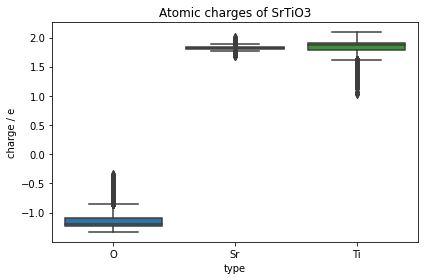

In [2]:
#!/usr/bin/env python

import numpy as np
import ase
import ase.db
import jax
import jax.numpy as jnp
import functools
import tqdm.auto
import typing
from preprocessing_base import get_cutoff_mask, get_init_charges, get_gaussian_distance_encodings
from jax import lax, random, numpy as jnp
import optax
import jraph
from typing import Any, Callable, Sequence, Optional
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections

DB_FILE_NAME = "data/SrTiO3_500.db"
# This is the element-to-type map used for generating the descriptors, which
# determines the order of the descriptor vector for each atom.
SORTED_ELEMENTS = sorted(["Sr", "Ti", "O"])
SYMBOL_MAP = {s: i for i, s in enumerate(SORTED_ELEMENTS)}

# 65 Oxygen atoms
# 15 Strontium atoms
# 25 Titanium atoms
type_to_AN_dict = {
    0: 8,
    1: 38,
    2: 22
}

type_to_charges_dict = {
    0: np.float64(-1.15),
    1: np.float64(1.83),
    2: np.float64(1.892)
}

# These labels identify each individual configuration in the larger
# database this small subsample was extracted from.
ind_labels = []
# Atom type, from 0 to n_types - 1.
types = []
# In case we want to use them for the electron-passing NN.
atomic_numbers = []
# Positions of each atom in each configuration, in Cartesian coordinates
# expressed in Å.
positions = []
# There are periodic boundary conditions in effect along the X and Y 
# directions. The length of the simulation box along those directions
# is stored in the elements [0, 0] and [1, 1] of the 3x3 matrices
# stored in this array. Although there is a cell matrix for each
# configuration, they are all the same in this case. The units are also
# Å. The [2, 2] element is immaterial, and the rest are zero.
cell_lengths = []
# Spherical Bessel descriptors for each atom, generated using the following
# parameters:
# N_MAX = 5
# R_CUT = 5.5
descriptors = []
# DDEC6 charges that we will try to predict,
charges = []

cell_size = np.array([])


all_atom_charges = collections.defaultdict(list)
with ase.db.connect(DB_FILE_NAME) as db:
    for idx, row in enumerate(tqdm.auto.tqdm(db.select(), total=db.count())):
        ind_labels.append(row["ind_label"])
        descriptors.append(row["data"]["bessel_descriptors"])
        charges.append(row["data"]["ddec6_charges"])

        atoms = row.toatoms()
        symbols = atoms.get_chemical_symbols()
        for (s, c) in zip(symbols, row["data"]["ddec6_charges"]):
            all_atom_charges[s].append(c)
        types.append([SYMBOL_MAP[s] for s in symbols])
        atomic_numbers.append(atoms.get_atomic_numbers())
        positions.append(atoms.get_positions())
        cell_lengths.append(atoms.cell.lengths())
        cell_size = atoms.cell

            

# def get_cell_lengths(cell):
#     return jnp.array(cell.lengths())

# v_get_cell_lengths = jnp.vectorize(get_cell_lengths)

descriptors = jnp.asarray(descriptors)
charges = jnp.asarray(charges)
types = jnp.asarray(types)
atomic_numbers = jnp.asarray(atomic_numbers)

positions = jnp.asarray(positions)
np_positions = deepcopy(positions)

# Check if all cell sizes are the same!
# If they are not, we need to use the correct ones for each distance calculation
cell_size = np.array(cell_size)
# Run this as cell size of z-axis is irrelevant
cell_size[2,2]=0.0
cell_size = jnp.array(cell_size)
cell_lengths = jnp.array(cell_lengths)
np_cell_lengths = deepcopy(cell_lengths)
cell_size


def melt_dict(dictionary):
    frame = pd.DataFrame.from_dict(dictionary, orient="index")
    return (
        frame.T.melt()
        .dropna()
        .rename(columns={"variable": "type", "value": "charge / e"})
    )

plt.figure()
sns.boxplot(x="type", y="charge / e", data=melt_dict(all_atom_charges))
plt.title(f"Atomic charges of SrTiO3")
plt.tight_layout()


plt.savefig("charts/gt_charges/SrTiO3.png")
plt.show()
# if np.array([cells[i]==cells[0] for i in range(len(cells))]).flatten().all():
#     cell_size = cells[0]

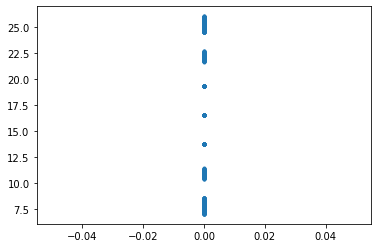

In [9]:
from itertools import compress
import jax.numpy as jnp

plt.plot(jnp.zeros(jnp.sum((types==2).flatten())),jnp.compress((types==2).flatten(),positions[:,:,2].flatten()),".")
# 
# plt.hist(positions[])

### Cell Size
The cell size is the size of the elemental cell in three dimensions

In [186]:
cell_lengths.shape
types.shape
types

DeviceArray([[0, 0, 0, ..., 2, 2, 2],
             [0, 0, 0, ..., 2, 2, 2],
             [0, 0, 0, ..., 2, 2, 2],
             ...,
             [0, 0, 0, ..., 2, 2, 2],
             [0, 0, 0, ..., 2, 2, 2],
             [0, 0, 0, ..., 2, 2, 2]], dtype=int32)

In [199]:
print(type(types))
def onehot_initialization(a):
    ncols = a.max()+1
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[all_idx(a, axis=2)] = 1
    return out

def all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

print(type(onehot_initialization(types)))

<class 'jaxlib.xla_extension.DeviceArray'>
<class 'numpy.ndarray'>


In [205]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5],[6]])
np.concatenate((a, b), axis=1)

array([[1, 2, 5],
       [3, 4, 6]])

### Bessel descriptors 

The Bessel descriptors describe the dynamics of the system with a 6x21 array for each atom in the slab. The first dimension describes the complete set of possible element-element pairs. The second axis describes angular and radial indices.

Can be treated as black box.

In [4]:
descriptors.shape

(500, 105, 6, 21)

### Charges

The charges are the target values to predict.

In [4]:
charges.shape

(500, 105)

The types describe the elements as categorical integers. The atomic numbers are described by their name. 

In [5]:
types[0]
atomic_numbers[0]
type_to_AN_dict = {
    0: 8,
    1: 38,
    2: 22
}

Positions are 3-dimensional arrays for each atom that describe their position.

In [55]:
positions.shape

(500, 105, 3)

# Batch distance calculations with single dimensions

In [130]:
print("Pos-Shape",np_positions.shape)


def calculate_xy_distance_numpy(v1: np.float32, v2: np.float32, cell_length: np.float32) -> np.float32:
    ''' Calculates the the distance of two values over the x- and y-axis with respect to periodic boundary conditions.
    Input:
        - v1: np.float32 - x- or y-value of first atom
        - v2: np.float32 - x- or y-value of second atom
        - cell_length: np.float32 - length of the elemental cell in the respective dimension
    Output:
        - distance in respective dimension
    '''
    delta = v1-v2
    delta = np.abs(delta - cell_length*np.floor(delta/cell_length,0))
    return delta

# v_calculate_xy_distance_numpy = np.vectorize(calculate_xy_distance_numpy, excluded = [2])
v_calculate_xy_distance_numpy = np.vectorize(calculate_xy_distance_numpy, signature = "(a),(),()->(a)")

def calculate_distances_numpy(pos1: np.array, positions: np.array, cell_size: np.array):
    ''' Calculates the the distance of two atom-positions in the 3D-space of the slab.
    Input:
        - pos1: np.array -> position of first atom
        - positions: np.array -> positions of all other atoms
        - cell_size: np.array -> size of elemental cell
    Output:
        - euclidean distance with respect to periodic boundary conditions
    '''
    assert pos1.shape == (3,) and positions.shape == (105,3) and cell_size.shape == (3,)
    x_distances = v_calculate_xy_distance_numpy(positions[:,0],pos1[0],cell_size[0])
    y_distances = v_calculate_xy_distance_numpy(positions[:,1],pos1[1],cell_size[1])
    z_distances = positions[:,2]-pos1[2]
    euclidean_distances = jnp.sqrt(x_distances**2 + y_distances**2 + z_distances**2)
    return euclidean_distances

# print(calculate_distances_numpy(np_positions[0][0],np_positions[0], np_cell_lengths[0]).shape)


def v_calculate_distances_numpy(positions: np.array, cell_lengths: np.array):
    ''' Calculates the the pairwise distances of all atom-positions in the 3D-space of the slab.
    Input:
        - positions: np.array -> positions of all atoms 
        - cell_lengths: np.array -> cell lengths repeated to fit batch size
    Output:
        - pairwise euclidean distances with respect to periodic boundary conditions for all atoms in this batch
    '''
    vmapped_func = np.vectorize(calculate_distances_numpy, excluded=[1,2], signature = "(a)->(b)")
    # positions_rep = np.repeat(positions[np.newaxis,:,:],105, axis=0)
    # cell_lengths_rep = np.repeat(np.array(cell_lengths)[np.newaxis,:],105, axis=0)
    return vmapped_func(positions,positions,cell_lengths)

def batch_calculate_distances_numpy(batch_positions: np.array, batch_cell_lengths: np.array):

    ''' Calculates the pairwise distance of atoms in the 3D-space of the slab vectorized for a batch.
    Input:
        - batch_positions: np.array -> batch of positions of all atoms 
        - batch_cell_lengths: np.array -> batch of cell lengths of second atom
    Output:
        - pairwise euclidean distances with respect to periodic boundary conditions for all atoms in all batches
    '''
    batch_v_calculate_distances = np.vectorize(v_calculate_distances_numpy, signature = "(b,c),(c)->(b,b)")
    batch_distances = batch_v_calculate_distances(batch_positions, batch_cell_lengths)
    return batch_distances



# print(np_cell_lengths.shape)
test_primitive_numpy = batch_calculate_distances_numpy(np_positions, np_cell_lengths)
print("Final-Shape:",test_primitive_numpy.shape)


Pos-Shape (500, 105, 3)
Final-Shape: (500, 105, 105)


In [3]:
def calculate_xy_distance(v1: jnp.float32, v2: jnp.float32, cell_length: jnp.float32) -> jnp.float32:
    ''' Calculates the the distance of two values over the x- and y-axis with respect to periodic boundary conditions.
    Input:
        - v1: jnp.float32 - x- or y-value of first atom
        - v2: jnp.float32 - x- or y-value of second atom
        - cell_length: jnp.float32 - length of the elemental cell in the respective dimension
    Output:
        - distance in respective dimension
    '''
    delta = v1-v2
    delta = jnp.abs(delta - cell_length*jnp.round(delta/cell_length,0))
    return delta

v_calculate_xy_distance = jnp.vectorize(calculate_xy_distance, excluded = [2])

def calculate_distances(pos1: jnp.array, positions: jnp.array, cell_size: jnp.array):
    ''' Calculates the the distance of two atom-positions in the 3D-space of the slab.
    Input:
        - pos1: jnp.array -> position of first atom
        - pos2: jnp.array -> position of second atom
        - cell_size: jnp.array -> size of elemental cell
    Output:
        - euclidean distance with respect to periodic boundary conditions
    '''
    assert pos1.shape == (3,) and positions.shape == (105,3) and cell_size.shape == (3,)
    x_distances = v_calculate_xy_distance(positions[:,0],pos1[0],cell_size[0])
    y_distances = v_calculate_xy_distance(positions[:,1],pos1[1],cell_size[1])
    z_distances = positions[:,2]-pos1[2]
    euclidean_distances = jnp.sqrt(x_distances**2 + y_distances**2 + z_distances**2)
    return euclidean_distances

@jax.jit
def v_calculate_distances(positions: jnp.array, cell_lengths: jnp.array):
    ''' Calculates the the pairwise distances of all atom-positions in the 3D-space of the slab.
    Input:
        - positions: jnp.array -> positions of all atoms 
        - cell_lengths: jnp.array -> cell lengths repeated to fit batch size
    Output:
        - pairwise euclidean distances with respect to periodic boundary conditions for all atoms in this batch
    '''
    vmapped_func = jax.vmap(calculate_distances)
    positions_rep = jnp.repeat(positions[np.newaxis,:,:],105, axis=0)
    cell_lengths_rep = jnp.repeat(jnp.array(cell_lengths)[jnp.newaxis,:],105, axis=0)
    return vmapped_func(positions,positions_rep,cell_lengths_rep)

@jax.jit
def batch_calculate_distances(batch_positions: jnp.array, batch_cell_lengths: jnp.array):
    ''' Calculates the pairwise distance of atoms in the 3D-space of the slab vectorized for a batch.
    Input:
        - batch_positions: jnp.array -> batch of positions of all atoms 
        - batch_cell_lengths: jnp.array -> batch of cell lengths of second atom
    Output:
        - pairwise euclidean distances with respect to periodic boundary conditions for all atoms in all batches
    '''
    batch_v_calculate_distances = jax.vmap(v_calculate_distances)
    batch_distances = batch_v_calculate_distances(batch_positions, batch_cell_lengths)
    return batch_distances

test_primitive = batch_calculate_distances(positions, cell_lengths)
# test_primitive

In [4]:
import seaborn as sns
sns.test_primitive

DeviceArray([[[ 0.       ,  2.8189359,  3.9317076, ..., 16.108505 ,
                5.310256 , 16.303452 ],
              [ 2.8189359,  0.       ,  3.071405 , ..., 15.916112 ,
                6.223685 , 16.157495 ],
              [ 3.9317076,  3.071405 ,  0.       , ..., 13.204901 ,
                7.1171083, 13.215829 ],
              ...,
              [16.108505 , 15.916112 , 13.204901 , ...,  0.       ,
               17.640598 ,  2.9136872],
              [ 5.310256 ,  6.223685 ,  7.1171083, ..., 17.640598 ,
                0.       , 18.932047 ],
              [16.303452 , 16.157495 , 13.215829 , ...,  2.9136872,
               18.932047 ,  0.       ]],

             [[ 0.       ,  2.7447882,  3.7491305, ..., 16.047197 ,
                5.1852894, 15.650999 ],
              [ 2.7447882,  0.       ,  2.5494273, ..., 16.015095 ,
                5.463197 , 15.510189 ],
              [ 3.7491305,  2.5494273,  0.       , ..., 13.590548 ,
                6.572677 , 12.978127 ],
       

# Batch distance calculations with jnp.einsum

In [114]:
# from functools import partial
# @partial(jax.jit, static_argnums=(1,))
# def jit_linalg(input, axis):
#     return jnp.linalg.norm(input, axis=axis)


def center_at_atoms_numpy(coordinates: np.ndarray, cell_size: np.ndarray):
    delta = coordinates - coordinates[:, np.newaxis, :]
    delta -= np.einsum(
        "ijk,kl",
        np.round(np.einsum("ijk,kl", delta, np.linalg.pinv(cell_size))),
        cell_size
    )    
    return jnp.linalg.norm(delta,axis=2)

def center_at_atoms_diagonal_numpy(coordinates: np.ndarray, cell_size_diagonal: np.ndarray):
    delta = coordinates - coordinates[:, np.newaxis, :]
    zero_indices = cell_size_diagonal == 0.
    icell_size_diagonal = np.where(zero_indices, 0., 1. / np.where(zero_indices, 1., cell_size_diagonal))
    delta -= cell_size_diagonal * np.round(delta * icell_size_diagonal)
    return jnp.sqrt(np.sum(delta**2, axis=-1))

v_center_at_atoms_diagonal_numpy = np.vectorize(center_at_atoms_diagonal_numpy, signature = "(a,b),(b)->(a,a)")


# # Vectorized version with vmap
v_center_at_atoms_numpy = np.vectorize(center_at_atoms_numpy, signature = "(a,b),(b,b)->(a,a)")
cell_size_rep = jnp.repeat(jnp.array(cell_size)[jnp.newaxis,:],500, axis=0)
test_einsum_numpy = v_center_at_atoms_numpy(positions,cell_size_rep)
test_diag_center_numpy = v_center_at_atoms_diagonal_numpy(positions,jnp.repeat(jnp.diag(cell_size)[jnp.newaxis,:],500, axis=0))
# test_diag_center = v_center_at_atoms_diagonal(positions,jnp.diag(cell_size))
# (center_at_atoms_numpy(np_positions[0],np.array(cell_size))==center_at_atoms(positions[0],cell_size)).all()

In [102]:
jnp.diag(cell_size)[jnp.newaxis,:]

DeviceArray([[ 5.5792565, 11.83539  ,  0.       ]], dtype=float32)

In [85]:
(center_at_atoms_diagonal_numpy(np_positions[0],jnp.diag(cell_size))==center_at_atoms_diagonal(positions[0],jnp.diag(cell_size))).all()
center_at_atoms_diagonal_numpy(np_positions[0],jnp.diag(cell_size)).shape

(105, 105)

In [115]:
from functools import partial
@partial(jax.jit, static_argnums=(1,))
def jit_linalg(input, axis):
    return jnp.linalg.norm(input, axis=axis)

@jax.jit
def center_at_atoms(coordinates: jnp.ndarray, cell_size: jnp.ndarray):
    delta = coordinates - coordinates[:, jnp.newaxis, :]
    delta -= jnp.einsum(
        "ijk,kl",
        jnp.round(jnp.einsum("ijk,kl", delta, jnp.linalg.pinv(cell_size))),
        cell_size
    )    
    return jit_linalg(delta,2)

def center_at_atoms_diagonal(coordinates: jnp.ndarray, cell_size_diagonal: jnp.ndarray):
    delta = coordinates - coordinates[:, jnp.newaxis, :]
    zero_indices = cell_size_diagonal == 0.
    icell_size_diagonal = jnp.where(zero_indices, 0., 1. / jnp.where(zero_indices, 1., cell_size_diagonal))
    delta -= cell_size_diagonal * jnp.round(delta * icell_size_diagonal)
    return jnp.sqrt(jnp.sum(delta**2, axis=-1))

v_center_at_atoms_diagonal = jax.jit(jax.vmap(center_at_atoms_diagonal))


# Vectorized version with vmap
v_center_at_atoms = jax.jit(jax.vmap(center_at_atoms))
cell_size_rep = jnp.repeat(jnp.array(cell_size)[jnp.newaxis,:],500, axis=0)
cell_size_diag_rep = jnp.repeat(jnp.diag(cell_size)[jnp.newaxis,:],500, axis=0)
test_einsum = v_center_at_atoms(positions,cell_size_rep)
test_diag_center = v_center_at_atoms_diagonal(positions,jnp.repeat(jnp.diag(cell_size)[jnp.newaxis,:],500, axis=0))

In [116]:
(test_diag_center_numpy==test_diag_center).all()
(test_einsum_numpy==test_einsum).all()

DeviceArray(True, dtype=bool)

In [120]:
center_at_atoms_jax_time = %timeit -o v_center_at_atoms(positions,cell_size_rep)


9.86 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
center_at_atoms_diag_jax_time = %timeit -o v_center_at_atoms_diagonal(positions,cell_size_diag_rep)

127 µs ± 5.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [124]:
batch_calculate_distances_jax_time = %timeit -o  batch_calculate_distances(positions, cell_lengths)

139 µs ± 2.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [125]:
center_at_atoms_np_time = %timeit -o v_center_at_atoms_numpy(positions,cell_size_rep)


679 ms ± 59.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [126]:
center_at_atoms_diag_np_time = %timeit -o v_center_at_atoms_diagonal_numpy(positions,cell_size_diag_rep)

610 ms ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [131]:
batch_calculate_distances_np_time = %timeit -o  batch_calculate_distances_numpy(positions, cell_lengths)

45 s ± 2.84 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


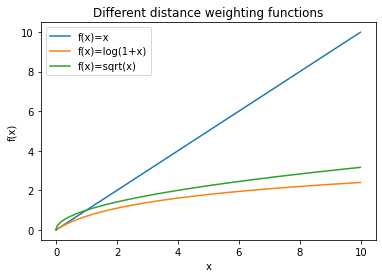

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define the functions
def f1(x):
    return x

def f2(x):
    return np.log(1 + x)

def f3(x):
    return x**(1/2)

# Create a numpy array with the x values in the range 0 to 10 with a step size of 0.01
x_values = np.arange(0, 10, 0.01)

# Create the line chart using matplotlib
plt.plot(x_values, [f1(x) for x in x_values], label='f(x)=x')
plt.plot(x_values, [f2(x) for x in x_values], label='f(x)=log(1+x)')
plt.plot(x_values, [f3(x) for x in x_values], label='f(x)=sqrt(x)')
plt.title('Different distance weighting functions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

# Save the figure
plt.savefig("charts/distance_weighting_functions.png")

# Show the plot
plt.show()

In [13]:
import pickle
# x = {
#     "cat_jax": center_at_atoms_jax_time.timings,
#     "catdiag_jax": center_at_atoms_diag_jax_time.timings,
#     "batch_jax": batch_calculate_distances_jax_time.timings,
#     "cat_np": center_at_atoms_np_time.timings,
#     "catdiag_np": center_at_atoms_diag_np_time.timings,
#     "batch_np": batch_calculate_distances_np_time.timings,
# }

with open('timings.pickle', 'rb') as handle:
    x = pickle.load(handle)


x["broadcasted\njax"] = x["catdiag_jax"]
x["broadcasted\nnumpy"] = x["catdiag_np"]
x["batched\njax"] = x["batch_jax"]
x["batched\nnumpy"] = x["batch_np"]

for key in ['cat_jax', 'catdiag_jax', 'batch_jax', 'cat_np', 'catdiag_np', 'batch_np']:
    x.pop(key)


with open('timings2.pickle', 'wb') as handle:
    pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)



x


{'broadcasted\njax': [0.00012415585000017016,
  0.00011968016770006216,
  0.0001230240552002215,
  0.00012776086129997566,
  0.00013861310360007337,
  0.000128642529499848,
  0.00012492070840016821],
 'broadcasted\nnumpy': [0.7268498670018744,
  0.585421829000552,
  0.5781094060002943,
  0.5632478770021407,
  0.5730971480006701,
  0.616754230002698,
  0.6248003059990879],
 'batched\njax': [0.00013775379159997102,
  0.0001432222544000979,
  0.00014086617169996316,
  0.00013751828640015445,
  0.00013714526740004658,
  0.00013882878219992562,
  0.00013518547269995905],
 'batched\nnumpy': [46.969564535000245,
  48.40330318999986,
  48.68118769400098,
  44.651580832000036,
  42.26169172400114,
  41.98485557499953,
  41.72309430399764]}

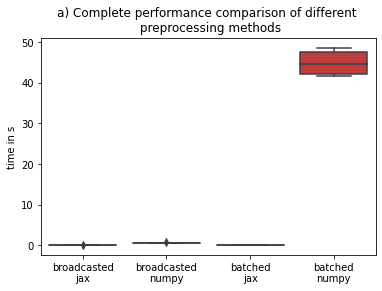

In [35]:
with open('timings2.pickle', 'rb') as handle:
    x = pickle.load(handle)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def melt_dict(dictionary):
    frame = pd.DataFrame.from_dict(dictionary, orient="index")
    return (
        frame.T.melt()
        .dropna()
        .rename(columns={"variable": "algorithm", "value": "time in s"})
    )


sns.boxplot(
    x="algorithm",
    y="time in s",
    data=melt_dict(
        x
    ),
).set(title="a) Complete performance comparison of different \n preprocessing methods", xlabel=None)

plt.savefig("charts/timings/boxplot.png")

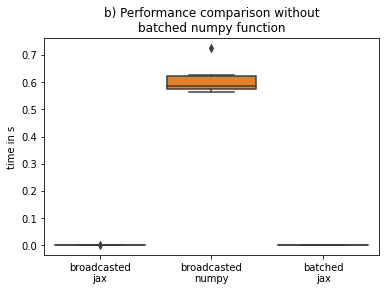

In [36]:
x.pop("batched\nnumpy")


sns.boxplot(
    x="algorithm",
    y="time in s",
    data=melt_dict(
        x
    ),
).set(title="b) Performance comparison without\nbatched numpy function", xlabel=None)
plt.savefig("charts/timings/boxplot_without_batchnp.png")

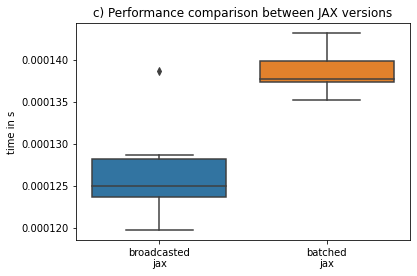

In [37]:
x.pop("broadcasted\nnumpy")


sns.boxplot(
    x="algorithm",
    y="time in s",
    data=melt_dict(
        x
    ),
).set(title="c) Performance comparison between JAX versions", xlabel=None)
plt.savefig("charts/timings/boxplot_without_numpy.png")

In [ ]:
from matplotlib import pyplot as plt

In [19]:
print((test_einsum == test_primitive).all())
print((test_diag_center == test_primitive).all())
print((test_einsum == test_diag_center).all())
print((test_primitive_numpy== test_primitive).all())
print((test_einsum == test_einsum_numpy).all())
print((test_diag_center == test_diag_center_numpy).all())


True
True
True
4583422


# Smooth Cutoff

[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]


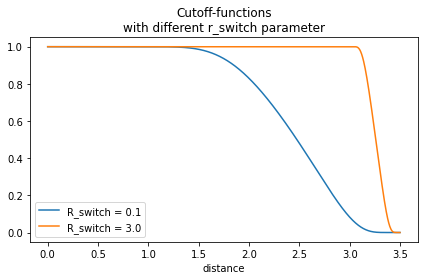

In [3]:
import jax
import jax.numpy as jnp
import functools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def _aux_function_f(t):
    "First auxiliary function used in the definition of the smooth bump."
    return jnp.where(t > 0., jnp.exp(-1. / jnp.where(t > 0., t, 1.)), 0.)


def _aux_function_g(t):
    "Second auxiliary function used in the definition of the smooth bump."
    f_of_t = _aux_function_f(t)
    return f_of_t / (f_of_t + _aux_function_f(1. - t))


def smooth_cutoff(r, r_switch, r_cut):
    """One-dimensional smooth cutoff function based on a smooth bump.

    This function follows the prescription given by Loring W. Tu in
    "An Introduction to Manifolds", 2nd Edition, Springer

    Args:
        r: The radii at which the function must be evaluated.
        r_switch: The radius at which the function starts differing from 1.
        r_cut: The radius at which the function becomes exactly 0.
    """
    r_switch2 = r_switch * r_switch
    r_cut2 = r_cut * r_cut

    return 1. - _aux_function_g((r * r - r_switch2) / (r_cut2 - r_switch2))





R_SWITCHES = [0.1,3.0]
R_CUT = 3.5
N_DERIVATIVES = 3


for R_SWITCH in R_SWITCHES:
    test_cutoff = functools.partial(smooth_cutoff,
                                    r_switch=R_SWITCH,
                                    r_cut=R_CUT)

    distance = jnp.linspace(0., R_CUT, num=1001)
    to_plot = test_cutoff
    for order in range(N_DERIVATIVES + 1):
        samples = jax.jit(jax.vmap(to_plot))(distance)
        print(samples)
        samples /= jnp.fabs(samples).max()
        plt.plot(distance, samples, label=f"R_switch = {R_SWITCH}")
        break
        to_plot = jax.grad(to_plot)

plt.xlabel("distance")
plt.title("Cutoff-functions\nwith different r_switch parameter")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("charts/smooth_cutoff.png")
plt.show()


In [21]:
batched_distances = test_diag_center
import preprocessing_base
x = preprocessing_base.get_gaussian_distance_encodings(batched_distances)

NameError: name 'test_diag_center' is not defined

# Cutoff from EPNN Github

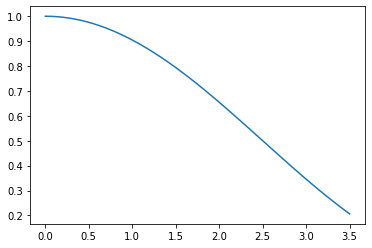

In [4]:
cutoff = 5.0
distance = np.array(distance)
C = (np.cos(np.pi * (distance - 0.0) / cutoff) + 1.0) / 2.0
C[distance >= cutoff] = 0.0
C[distance <= 0.0] = 1.0
plt.plot(distance, C)
plt.show()

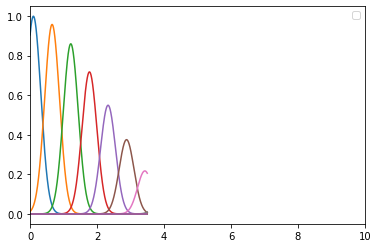

In [9]:
import numpy as np
eta= 10
mus = np.linspace(0.1,8.0, 15)
for mu in mus:
    y = C*np.exp(-eta * (distance-mu)**2)
    plt.plot(distance, y)
plt.legend()
plt.xlim((0,10))
plt.show()

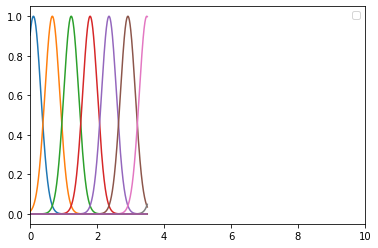

In [10]:
eta= 10
mus = np.linspace(0.1,8.0, 15)
for mu in mus:
    y = np.exp(-eta * (distance-mu)**2)
    plt.plot(distance, y)
plt.legend()
plt.xlim((0,10))
plt.show()

# Our cutoff

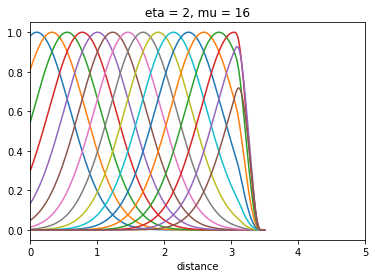

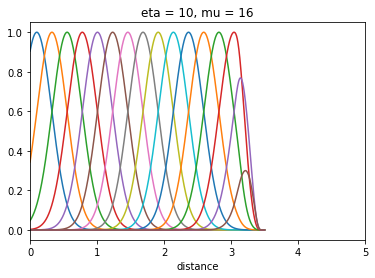

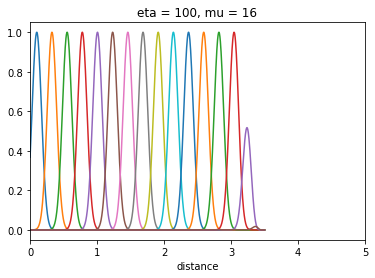

In [8]:

mus = np.linspace(0.1,3.5, 16)
for i, eta in enumerate([2,10,100]):
    for mu in mus:
        y = jax.jit(jax.vmap(test_cutoff))(distance)*np.exp(-eta * (distance-mu)**2)
        plt.plot(distance, y)
        plt.xlabel("distance")
    plt.xlim((0,5))
    plt.title(f"eta = {eta}, mu = 16")
    plt.savefig(f"charts/eta_{eta}.png")
    plt.show()
# plt.subplots_adjust(right=2.0, top= 0.6, wspace=0.1)


In [3]:
import importlib
importlib.reload(preprocessing)
preprocessing.get_init_charges(types,
                                "specific",
                                type_to_charges_dict,
                                jnp.zeros(500))
preprocessing.get_init_charges(types,
                                "average",
                                type_to_charges_dict,
                                jnp.zeros(500))

NameError: name 'preprocessing' is not defined

In [ ]:
def center_at_atoms_diagonal(coordinates: jnp.ndarray, cell_size_diagonal: jnp.ndarray):
    """ Vectorized version: v_center_at_atoms_diagonal -> Calculate the distances towards each atom inside of the batched coordinate array

    Input:
        - coordinates (n_atom x 3 (dimensions)): Coordinates of each atom.
        - cell_size_diagonal (3): Diagonal values of the cell_size matrix. [2,2] = 0 as it is irrelevant.
    Output:
        - distances: (n_atom x n_atom)
    """
    delta = coordinates - coordinates[:, jnp.newaxis, :]
    zero_indices = cell_size_diagonal == 0.
    icell_size_diagonal = jnp.where(zero_indices, 0., 1. / jnp.where(zero_indices, 1., cell_size_diagonal))
    delta -= cell_size_diagonal * jnp.round(delta * icell_size_diagonal)
    return jnp.sqrt(jnp.sum(delta**2, axis=-1))




### Transpose operations as examples

In [306]:
# 2 atoms
A = np.array([
    [1,2,3],
    [4,5,6]
    ])
A = np.tile(np.expand_dims(A,1),(1,2,1))
A

array([[[1, 2, 3],
        [1, 2, 3]],

       [[4, 5, 6],
        [4, 5, 6]]])

In [299]:
A_t = A.transpose(1,0,2)
A_t

array([[[1, 2, 3],
        [4, 5, 6]],

       [[1, 2, 3],
        [4, 5, 6]]])

In [303]:
A_r = np.reshape(A, [-1, A.shape[-1]])
A_t_r = np.reshape(A_t, [-1, A_t.shape[-1]])
print(A_r)
A_t_r

[[1 2 3]
 [1 2 3]
 [4 5 6]
 [4 5 6]]


array([[1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6]])

In [308]:
np.reshape(A_r, [-1, 2, 2, 3])

(1, 2, 2, 3)

In [3]:
from preprocessing_jraph import get_init_crystal_states


key, subkey = random.split(random.PRNGKey(0))
h_dim = 126
e_dim = 48
layers = [32,32,1] # hidden layers
T = 3
path = "data/SrTiO3_500.db"
n_elems = 3


descriptors, distances_encoded, init_charges, gt_charges, cutoff_mask = get_init_crystal_states(path, edge_encoding_dim = e_dim, SAMPLE_SIZE = None) # Change sample size to None if all samples should be read.

  0%|          | 0/500 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 5)

In [4]:
class MLP_flax(nn.Module):
# TODO: Question: Do we need the output dimension as another feature?=
  features: Sequence[int]
  @nn.compact
  def __call__(self, x, y):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

model = MLP_flax(layers)

In [5]:
x = random.uniform(key, (4,4))
y = random.uniform(key, (4,4))
init_variables = model.init(subkey, x, y=y)
y = model.apply(init_variables, x=x, y=y)


In [43]:
jax.tree_map(lambda x: x.shape, init_variables)

FrozenDict({
    params: {
        Dense_0: {
            bias: (32,),
            kernel: (4, 32),
        },
        Dense_1: {
            bias: (32,),
            kernel: (32, 32),
        },
        Dense_2: {
            bias: (1,),
            kernel: (32, 1),
        },
    },
})

In [6]:
descriptors.shape

(500, 105, 126)

# Testing jraph

In [1]:
from preprocessing_jraph import get_init_crystal_states
# import ase.db
import jax
import typing
# from preprocessing import get_cutoff_mask, get_init_charges, get_gaussian_distance_encodings, v_center_at_atoms_diagonal, type_to_charges_dict, SYMBOL_MAP
from jax import lax, random, numpy as jnp
import optax
import jraph
from typing import Any, Callable, Sequence, Optional, Tuple


key, subkey = random.split(random.PRNGKey(0))
h_dim = 126
e_dim = 48
layers = [32,32,1] # hidden layers
T = 3
path = "data/SrTiO3_500.db"
n_elems = 3
R_SWITCH = 0.5
R_CUT = 3.0


descriptors, distances, distances_encoded, init_charges, gt_charges, cutoff_mask = get_init_crystal_states(path, edge_encoding_dim = e_dim, SAMPLE_SIZE = None, r_switch = 0.5, r_cut = 5.0) # Change sample size to None if all samples should be read.

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
def create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors, distances, distances_encoded, init_charges, cutoff_mask, cutoff = R_CUT):
    batch_size = descriptors.shape[0]
    natom = descriptors.shape[1]
    # Reshaping the descriptors to go over the whole batch
    descriptors = jnp.reshape(descriptors,(batch_size*natom,descriptors.shape[2]))
    
    # to calculate the number of edges for each individual graph
    distances_flattened_batchwise = jnp.reshape(distances,(batch_size,natom*natom))
    n_edges = jnp.count_nonzero(jnp.logical_and(distances_flattened_batchwise > 0, distances_flattened_batchwise < cutoff),axis=1)
    n_nodes = jnp.repeat(jnp.array([natom]),batch_size)
    # Create a flattened index over all previously diagonal elements to be able to delete them from the flattened arrays.
    flatten_idx = jnp.nonzero(jnp.logical_and(distances.flatten() > 0, distances.flatten() < cutoff))[0]
    idx = jnp.nonzero(jnp.logical_and(distances.flatten() > 0, distances.flatten() < cutoff))[0]
    # Make sure that there are only edges between nodes of the same graph
    # Batch range to add onto the tiled outer products
    batch_range = jnp.reshape(jnp.repeat(jnp.arange(batch_size)*natom,natom*natom),(batch_size,natom,natom))
    # outer product over the atoms
    outer = jnp.tile(jnp.outer(jnp.ones(natom),jnp.arange(natom)).astype(jnp.int32),batch_size).reshape(batch_size,natom,natom)
    # transposed for the other variant
    outer_transposed = jnp.transpose(outer, axes=(0,2,1))
    senders = jnp.add(outer_transposed,batch_range).flatten()[flatten_idx]
    receivers = jnp.add(outer,batch_range).flatten()[flatten_idx]
    sender_descriptors = descriptors[senders,:]
    receiver_descriptors = descriptors[senders,:]
    # Encoded distances are also flattened. Combinations of the same node (diagonal) are deleted
    graph_edges = jnp.reshape(distances_encoded,(distances_encoded.shape[0]*distances_encoded.shape[1]*distances_encoded.shape[2],48))[flatten_idx,:]
    # Same for cutoff_mask
    cutoff_mask = cutoff_mask.flatten()[flatten_idx]
    # Nodes contain charges
    # Edges contain concatenation of descriptors, edge_embeddings and cutoff_mask (which will be removed in the Network)
    graph= jraph.GraphsTuple(nodes = init_charges.flatten(),
                            # nodes = jnp.concatenate([descriptors,init_charges],axis=-1), Alternative 
                            senders = senders,
                            receivers = receivers,
                            edges = jnp.concatenate([receiver_descriptors, sender_descriptors, graph_edges, jnp.expand_dims(cutoff_mask,axis=-1)],axis=-1),
                            n_node = n_nodes,
                            n_edge = n_edges,
                            globals = None)
    return graph

size = 50
graph = create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors[:size],distances[:size], distances_encoded[:size],init_charges[:size],cutoff_mask[:size])
graph2 = create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors[size:size*2],distances[size:size*2], distances_encoded[size:size*2],init_charges[size:size*2],cutoff_mask[size:size*2])
# graph = create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors,distances, distances_encoded,init_charges,cutoff_mask)

In [4]:
def print_graph_stats(graph):
    print("Nodes-Shape:",graph[0].shape)
    print("Edges-Shape:",graph[1].shape)
    print("Senders-Length:",graph[2].shape)
    print("Globals:",None if graph[4] is None else graph[4].shape)
    print("n_nodes:",graph[5])
    print("n_edges:",graph[6])

print_graph_stats(graph)

Nodes-Shape: (5250,)
Edges-Shape: (47516, 301)
Senders-Length: (47516,)
Globals: None
n_nodes: [105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105
 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105
 105 105 105 105 105 105 105 105 105 105 105 105 105 105]
n_edges: [958 942 926 954 942 950 950 966 974 958 970 934 962 946 942 958 930 958
 954 950 954 958 946 938 986 958 946 942 930 954 930 950 966 974 958 958
 922 962 958 934 934 938 950 966 946 938 926 954 970 946]


In [13]:
import jax.tree_util as tree
import haiku as hk

def aggregate_edges_for_nodes_fn(edges: jnp.array,
                                receivers: jnp.array,
                                cutoff_mask: jnp.array,
                                n_nodes: int) -> jnp.array:
  edges = jnp.multiply(edges,cutoff_mask)
  return jax.ops.segment_sum(edges,receivers,n_nodes)


class MLP_haiku(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))
    mlp = hk.Sequential(layers)
    return mlp(x)



# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphElectronPassing(aggregate_edges_for_nodes_fn: Callable,
                        MLP: Callable,
                        h_dim: int = 126) -> Callable:
  """
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_edges_for_nodes_fn: function used to aggregates the sender nodes.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGEP(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    receiver_descriptors = edges[:,:h_dim]
    sender_descriptors=edges[:,h_dim:h_dim*2]
    graph_edges = edges[:,h_dim*2:-1]
    cutoff_mask = jnp.expand_dims(edges[:,-1],axis=-1)
    sender_charges = jnp.expand_dims(nodes[senders],axis=-1)
    receiver_charges = jnp.expand_dims(nodes[receivers],axis=-1)
    # Neural network forward: NN(q_v, q_w, h_v, h_w, e_vw) from the paper
    edges = jnp.concatenate([receiver_charges, sender_charges, receiver_descriptors, sender_descriptors, edges],axis=-1)
    edges_reversed = jnp.concatenate([sender_charges, receiver_charges, sender_descriptors, receiver_descriptors, edges],axis=-1)
    # Subtraction of both outputs to create electron-passing-output for atom v
    MLP_outputs = jnp.subtract(MLP(edges),MLP(edges_reversed))
    # aggregate_edges_for_nodes_fn is the weighting function with the cutoff_mask
    received_attributes = tree.tree_map(
      lambda e: aggregate_edges_for_nodes_fn(e, receivers, cutoff_mask, nodes.shape[0]), MLP_outputs)
    nodes = received_attributes.flatten()
    return graph._replace(nodes=nodes)
  return _ApplyGEP


gep_layer = GraphElectronPassing(
    aggregate_edges_for_nodes_fn=aggregate_edges_for_nodes_fn,
    MLP = lambda n: MLP_haiku(features=[32,32, 1])(n),
)

model = hk.without_apply_rng(hk.transform(gep_layer))
params = model.init(jax.random.PRNGKey(42), graph)
true_labels = gt_charges[:size].flatten()
opt_init, opt_update = optax.adam(1e-2)
opt_state = opt_init(params)

out_graph = model.apply(params,graph)
# out_graph = model.apply(params,out_graph)
# out_graph = model.apply(params,out_graph)


@jax.jit
def rmse_loss(params: hk.Params, graph: jraph.GraphsTuple, num: int = 2) -> jnp.ndarray:
    # hk.fori_loop(0,3, model.apply, graph, params=params)
    output = model.apply(params, graph)
    for i in range(num-1):
      output = model.apply(params, output)
    # output = model.apply(params, output)
    # output = model.apply(params, output)
    return jnp.sqrt(jnp.sum(jnp.square(output[0]-true_labels)/len(true_labels)))

@jax.jit
def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    """Returns updated params and state."""
    g = jax.grad(rmse_loss)(params, graph)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

print(rmse_loss(params, graph),rmse_loss(params, graph2)) 
for i in range(1000):
  params, opt_state = update(params, opt_state)
  if (i % 50)==0:
    print(rmse_loss(params, graph),rmse_loss(params, graph2)) 

1.856807 1.8580811
3.8308196 3.8638172
0.09564987 0.10641497
0.0668511 0.096709535
0.055792082 0.09580475
0.069272935 0.11015806
0.0498236 0.095877685
0.048439573 0.098490395
0.042463552 0.09518825
0.04067907 0.09361523
0.038109843 0.09509958
0.04537543 0.09781234
0.042935856 0.09946415
0.036875077 0.0985065
0.032127447 0.095437154
0.033544343 0.098853484
0.04245481 0.090950415
0.031996608 0.10080125
0.030216122 0.097705975
0.03690572 0.10382945
0.028763974 0.097937055


In [2]:
# def create_graphsTuple_with_encoded_distances(descriptors, distances, distances_encoded, init_charges, cutoff_mask, cutoff = R_CUT):
#     natom = descriptors.shape[0]
#     # Create a flattened index over all previously diagonal elements to be able to delete them from the flattened arrays. 
#     flatten_idx = jnp.nonzero(jnp.logical_and(distances > 0, distances < cutoff).flatten())[0]
#     senders = jnp.outer(jnp.ones(natom),jnp.arange(natom)).T.flatten()[flatten_idx].astype(jnp.int32)
#     receivers = jnp.outer(jnp.ones(natom),jnp.arange(natom)).flatten()[flatten_idx].astype(jnp.int32)
#     sender_descriptors = descriptors[senders,:]
#     # print(senders,receivers)
#     receiver_descriptors = descriptors[senders,:]
#     n_nodes = jnp.array([natom])
#     n_edges = jnp.array([natom*natom-natom])
#     # Encoded distances are also flattened. Combinations of the same node (diagonal) are deleted
#     graph_edges = jnp.reshape(distances_encoded,(distances_encoded.shape[0]*distances_encoded.shape[1],48))[flatten_idx,:]
#     # Same for cutoff_mask
#     cutoff_mask = cutoff_mask.flatten()[flatten_idx]
#     # Nodes contain charges
#     # Edges contain concatenation of descriptors, edge_embeddings and cutoff_mask (which will be removed in the Network)
#     graph= jraph.GraphsTuple(nodes = init_charges,
#                             # nodes = jnp.concatenate([descriptors,init_charges],axis=-1), Alternative 
#                             senders = senders,
#                             receivers = receivers,
#                             edges = jnp.concatenate([receiver_descriptors, sender_descriptors, graph_edges, jnp.expand_dims(cutoff_mask,axis=-1)],axis=-1),
#                             n_node = n_nodes,
#                             n_edge = n_edges,
#                             globals = None)
#     return graph

# graph = create_graphsTuple_with_encoded_distances(descriptors[0],distances[0], distances_encoded[0],init_charges[0],cutoff_mask[0])

In [6]:
# natom = 4
# batch_size = 2

# batch_range = jnp.reshape(jnp.repeat(jnp.arange(batch_size)*natom,natom*natom),(batch_size,natom,natom))
# outer = jnp.tile(jnp.outer(jnp.ones(natom),jnp.arange(natom)).astype(jnp.int32),batch_size).reshape(batch_size,natom,natom)
# outer_transposed = jnp.transpose(outer, axes=(0,2,1))
# senders = jnp.add(outer_transposed,batch_range).flatten()
# receivers = jnp.add(outer,batch_range).flatten()

# senders, receivers

# Ionic Liquid

  0%|          | 0/368 [00:00<?, ?it/s]

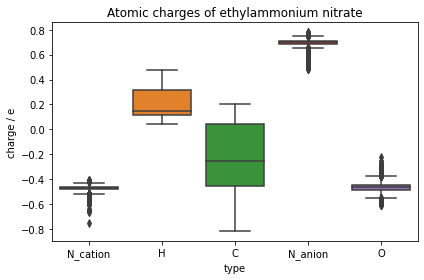

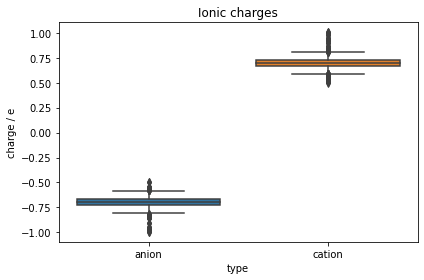

In [10]:
import enum
import json
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ase
import ase.io
import ase.db

import tqdm.auto

np.set_printoptions(linewidth=np.inf)

DB_FILE_NAME = "data/IL_charges.db"
N_ATOMS_CATION = 11
N_ATOMS_ANION = 4
N_DB = 368
FORMULA = "C30H120N30O45"

if __name__ == "__main__":
    all_atom_charges = collections.defaultdict(list)
    all_cation_charges = []
    all_anion_charges = []
    positions= []
    with ase.db.connect(DB_FILE_NAME) as db:
        for row in tqdm.auto.tqdm(db.select(), total=db.count()):
            charges = np.asarray(row["data"]["ddec6_charges"])
            atoms = row.toatoms()
            positions.append(atoms.get_positions())      


            symbols = atoms.get_chemical_symbols()
            n_pairs = len(symbols) // (N_ATOMS_CATION + N_ATOMS_ANION)
            extended_symbols = []
            for i, s in enumerate(symbols):
                if s == "N":
                    if i < n_pairs * N_ATOMS_CATION:
                        extended_symbols.append("N_cation")
                    else:
                        extended_symbols.append("N_anion")
                else:
                    extended_symbols.append(s)
            symbols = extended_symbols

            for (s, c) in zip(symbols, charges):
                all_atom_charges[s].append(c)
            cation_charges = (
                charges[: N_ATOMS_CATION * n_pairs]
                .reshape((-1, N_ATOMS_CATION))
                .sum(axis=1)
            )
            all_cation_charges.extend(cation_charges.tolist())
            anion_charges = (
                charges[N_ATOMS_CATION * n_pairs :]
                .reshape((-1, N_ATOMS_ANION))
                .sum(axis=1)
            )
            all_anion_charges.extend(anion_charges.tolist())

    def melt_dict(dictionary):
        frame = pd.DataFrame.from_dict(dictionary, orient="index")
        return (
            frame.T.melt()
            .dropna()
            .rename(columns={"variable": "type", "value": "charge / e"})
        )

    plt.figure()
    sns.boxplot(x="type", y="charge / e", data=melt_dict(all_atom_charges))
    plt.title(f"Atomic charges of ethylammonium nitrate")
    plt.tight_layout()
    plt.savefig("charts/gt_charges/ethylammoniumnitrate.png")
    plt.figure()
    sns.boxplot(
        x="type",
        y="charge / e",
        data=melt_dict(
            dict(anion=all_anion_charges, cation=all_cation_charges)
        ),
    )
    plt.title(f"Ionic charges")
    plt.tight_layout()

    plt.show()


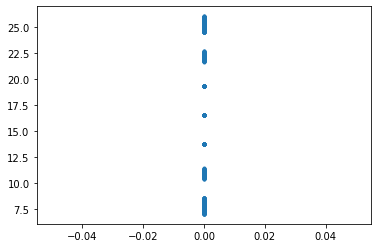

In [11]:
from itertools import compress
import jax.numpy as jnp

plt.plot(jnp.zeros(jnp.sum((types==2).flatten())),jnp.compress((types==2).flatten(),positions[:,:,2].flatten()),".")

In [25]:
atoms

Atoms(symbols='C30H120N30O45', pbc=True, cell=[12.899999618530273, 12.899999618530273, 12.899999618530273])

In [1]:
import numpy as np
import math
import json
import ase
import ase.db
import jax
import jax.numpy as jnp
import functools
import tqdm.auto
import typing
from preprocessing_base import get_cutoff_mask, get_init_charges, get_gaussian_distance_encodings, v_center_at_atoms_diagonal
from preprocessing_jraph import get_init_crystal_states, get_init_distances
from jax import lax, random, numpy as jnp
import optax
import jraph
from typing import Any, Callable, Sequence, Optional


# def get_init_crystal_states(distance_encoding_type = "root", # ["log1","root","none"] 
#                             r_switch = 1.0,
#                             r_cut = 1.5,
#                             edge_encoding_dim = 126,
#                             eta = 2.0, # gaussian encoding variable
#                             SAMPLE_SIZE = None,
#                             init_type = "specific",
#                             formula = "SrTiO3",
#                             ):
#     """ Returns preprocessed relevant data from the crystal database.

#     Input:
#         - filepath: Filepath to database
#         - distance_encoding_type: str -> Type of distance encoding
#             gaussian: Gaussian encoding over a number of dims. 
#         - r_switch: The radius at which the function starts differing from 1.
#         - r_cut: The radius at which the function becomes exactly 0.
#     Output:
#         - Dictionary with keys:
#             - "charges": ground truth charges for each atom in each slab (batchsize x n_atom)
#             - "types": element info of each atom encoded (batchsize x n_atom) (0 = Oxygen, 1 = Strontium, 2 = Titanium)
#             - "atomic_numbers": atomic number of each atom (batchsize x n_atom) (8 = Oxygen, 38 = Strontium, 22 = Titanium)
#             - "positions": positions of all atoms (batchsize x n_atom x 3)
#             - "distances": pairwise distances between all atoms (batchsize x n_atom x n_atom)
#     """
#     N_ATOMS_CATION = 11
#     N_ATOMS_ANION = 4
#     # all_atom_charges = collections.defaultdict(list)
#     # all_cation_charges = []
#     # all_anion_charges = []
#     # Reading relevant data from presets file.
#     try:
#         with open (os.getcwd()+"/presets.json") as f:
#             presets = json.load(f)
#             presets = presets[formula]
#     except:
#         print("Presets:", presets)
#         raise ValueError(f"Formula {formula} not found in presets.json.")
#     path = presets["path"]
#     type_to_charges_dict = {int(k):v for k,v in presets["charge_map"].items()}
#     SYMBOL_MAP = presets["symbol_map"]
    
#     # Atom type, from 0 to n_types - 1.
#     types = []
#     # In case we want to use them for the electron-passing NN.
#     atomic_numbers = []
#     # Positions of each atom in each configuration, in Cartesian coordinates
#     # expressed in Å.
#     positions = []
#     # There are periodic boundary conditions in effect along the X and Y 
#     # directions. The length of the simulation box along those directions
#     # is stored in the elements [0, 0] and [1, 1] of the 3x3 matrices
#     # stored in this array. Although there is a cell matrix for each
#     # configuration, they are all the same in this case. The units are also
#     # Å. The [2, 2] element is immaterial, and the rest are zero.
#     cell_lengths = []
#     # Spherical Bessel descriptors for each atom, generated using the following
#     # parameters:
#     # N_MAX = 5
#     # R_CUT = 5.5
#     descriptors = []
#     # DDEC6 charges that we will try to predict,
#     charges = []

#     cell_size = np.array([])

#     with ase.db.connect(path) as db:
#         for idx, row in enumerate(tqdm.auto.tqdm(db.select(), total=db.count())):
#             descriptors.append(row["data"]["bessel_descriptors"])
#             charges.append(row["data"]["ddec6_charges"])

#             atoms = row.toatoms()
            
#             #########################################################
#             #########################################################
#             symbols = atoms.get_chemical_symbols()
#             n_pairs = len(symbols) // (N_ATOMS_CATION + N_ATOMS_ANION)
#             extended_symbols = []
#             for i, s in enumerate(symbols):
#                 if s == "N":
#                     if i < n_pairs * N_ATOMS_CATION:
#                         extended_symbols.append("N_cation")
#                     else:
#                         extended_symbols.append("N_anion")
#                 else:
#                     extended_symbols.append(s)
#             symbols = extended_symbols

#             # for (s, c) in zip(symbols, charges[-1]):
#             #     all_atom_charges[s].append(c)
#             # cation_charges = (
#             #     charges[-1][: N_ATOMS_CATION * n_pairs]
#             #     .reshape((-1, N_ATOMS_CATION))
#             #     .sum(axis=1)
#             # )
#             # all_cation_charges.extend(cation_charges.tolist())
#             # anion_charges = (
#             #     charges[-1][N_ATOMS_CATION * n_pairs :]
#             #     .reshape((-1, N_ATOMS_ANION))
#             #     .sum(axis=1)
#             # )
#             # all_anion_charges.extend(anion_charges.tolist())
#             #########################################################
#             #########################################################

#             types.append([SYMBOL_MAP[s] for s in symbols])
#             atomic_numbers.append(atoms.get_atomic_numbers())
#             positions.append(atoms.get_positions())
#             cell_lengths.append(atoms.cell.lengths())
#             cell_size = atoms.cell
#             if SAMPLE_SIZE and (SAMPLE_SIZE-1) <= idx:
#                 break
#     if not SAMPLE_SIZE:
#         SAMPLE_SIZE = idx+1
#     # Descriptor tensors are reshaped to flatten to bessel descriptors
#     descriptors = jnp.asarray(descriptors)
#     descriptors = descriptors.reshape(*descriptors.shape[:2],-1)
#     positions = jnp.asarray(positions)
#     types = jnp.asarray(types)
#     gt_charges = jnp.asarray(charges)
#     total_charges = jnp.repeat(jnp.float32(presets["total_charge"]), SAMPLE_SIZE)
#     natom = positions.shape[1]
    
#     # This can be changed to "average", so all charges are initialized as 0.0
#     init_charges = get_init_charges(types,
#                                     init_type,
#                                     type_to_charges_dict,
#                                     total_charges)
#     init_charges = jnp.expand_dims(init_charges,axis=-1)


#     cell_size = np.array(cell_size)
#     cell_size = jnp.array(cell_size)
#     if formula == "SrTiO3":
#         # Run this as cell size of z-axis is irrelevant for SrTiO3
#         cell_size[2,2]=0.0
#     distances = v_center_at_atoms_diagonal(positions,jnp.repeat(jnp.diag(cell_size)[jnp.newaxis,:],SAMPLE_SIZE, axis=0))
#     cutoff_mask = get_cutoff_mask(batched_distances = distances, R_SWITCH = r_switch, R_CUT = r_cut)
#     if distance_encoding_type=="log1":
#         distances_encoded = get_gaussian_distance_encodings(batched_distances = jnp.log(distances+1.0), ETA = eta, R_CUT = math.log(r_cut+1), dim_encoding = edge_encoding_dim)
#     elif distance_encoding_type=="root":
#         distances_encoded = get_gaussian_distance_encodings(batched_distances = jnp.sqrt(distances), ETA = eta, R_CUT = math.sqrt(r_cut), dim_encoding = edge_encoding_dim)
#     else:
#         distances_encoded = get_gaussian_distance_encodings(batched_distances = distances, ETA = eta, R_CUT = r_cut, dim_encoding = edge_encoding_dim)
#     return descriptors, distances, distances_encoded, init_charges, gt_charges, cutoff_mask, types

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

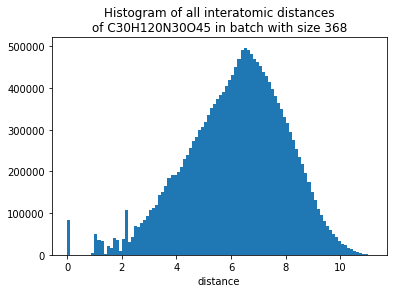

In [8]:
formula = "C30H120N30O45"
# formula = "SrTiO3"
distances, cutoff_mask = get_init_distances(
                            r_switch = 0.5,
                            r_cut = 9.0,
                            formula = formula
                            )


import matplotlib.pyplot as plt
# descriptors.shape
flat_distances = np.asarray(distances.flatten())
flat_cutoff_mask = np.asarray(cutoff_mask.flatten())
# init_charges.shape
# gt_charges.shape
# cutoff_mask.shape
# plt.hist(flat_distances*flat_cutoff_mask, bins = 100)
distances.shape
plt.hist(flat_distances, bins = 100)
plt.title(f"Histogram of all interatomic distances\nof {formula} in batch with size 368")
plt.xlabel("distance")
plt.savefig(f"charts/distances/{formula}_distances.png")

In [51]:
import jax
from jax import numpy as jnp
import jraph
from typing import Any
import warnings
import numpy as np
import haiku as hk
import pandas as pd
from hyperoptimization_utils import run_grid_hyperparam_pipeline, train_single_model, load_model

#######################################
###### HYPERPARAMETERS ################
OVERWRITE = True
#
E_DIM = 16
R_SWITCH = 0.1
R_CUT = 10.0
DISTANCE_ENCODING_TYPE = "none"
FEATURES = [64,32,32,1]
NUM_PASSES = 2
ACTIVATION = "relu"
N_EPOCHS = 50
FORMULA = "C30H120N30O45"

DEFAULT_DICT = {
    "E_DIM" : E_DIM,
    "R_SWITCH" : R_SWITCH,
    "R_CUT" : R_CUT,
    "DISTANCE_ENCODING_TYPE" : DISTANCE_ENCODING_TYPE,
    "FEATURES" : FEATURES,
    "NUM_PASSES" : NUM_PASSES,
    "ACTIVATION" : ACTIVATION,
    "N_EPOCHS" : N_EPOCHS,
    "PATH" : PATH,
}

OPTIM_DICT = {
    "FEATURES":[[64,32,32,1],[64,4,1]],
    "NUM_PASSES": [2,3]
}

model_results, batches = train_single_model(E_DIM, R_SWITCH, R_CUT, DISTANCE_ENCODING_TYPE, FEATURES, NUM_PASSES, ACTIVATION, N_EPOCHS, OVERWRITE = True, FORMULA = FORMULA, SAVE_MODEL = False)


0.0